In [1]:
# imports

import json
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from barnacle import visualize_3d_tensor, plot_factors_heatmap
from pathlib import Path
from sklearn.model_selection import ParameterGrid
import tensorly as tl
from tlab.cp_tensor import load_cp_tensor
import tlviz
from tlviz.factor_tools import factor_match_score, cosine_similarity
from tlviz.model_evaluation import relative_sse
import xarray as xr
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)


In [2]:
# set aesthetic parameters

line_color = '#0F0A0A'    # dark
# line_color = '#E5E4E2'    # light

neutral_color = '#E0E0E0'

# thursday
accent_colors = ['#9B5DE5', '#FFAC69', '#00C9AE', '#FD3F92', '#0F0A0A', 
                 '#959AB1', '#FFDB66', '#FFB1CA', '#63B9FF', '#4F1DD7']

style = {'axes.edgecolor': line_color,
         'axes.labelcolor': line_color,
         'text.color': line_color,
         'xtick.color': line_color,
         'ytick.color': line_color,
         'font.family': 'Helvetica',
         'font.Helvetica': ['Helvetica']}

palette = sns.color_palette(accent_colors)

sns.set_context('talk', rc={'lines.linewidth': 2})
sns.set_palette(palette)
# sns.set_palette('tab20')
sns.set_style('ticks', style)

plt.rcParams['legend.frameon'] = False
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.facecolor'] = 'none'
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['patch.linewidth'] = 0
plt.rcParams['patch.edgecolor'] = 'none'
plt.rcParams['savefig.dpi'] = 100

# utility function for moving histplot legends
def move_legend(ax, new_loc, **kws):
    old_legend = ax.legend_
    handles = old_legend.legendHandles
    labels = [t.get_text() for t in old_legend.get_texts()]
    title = old_legend.get_title().get_text()
    ax.legend(handles, labels, loc=new_loc, title=title, **kws)
    

# Collect data

In [3]:
# gather cross validation data

data_dir = Path('../../data/4-fitting')
outdir = Path('.')

results_df = pd.DataFrame()
for cyano in ['pro', 'syn']:
    df = pd.read_csv(data_dir / cyano / 'cv_data.csv')
    df['genus'] = cyano
    if len(df) == 0:
        results_df = df
    else:
        results_df = pd.concat([results_df, df])

# add features
results_df['comparison'] = (results_df['modeled_replicate'] == results_df['comparison_replicate']).map({
    True: 'Fitting', False: 'Cross-Validation'
})
results_df = results_df.sort_values(
    ['genus', 'bootstrap_id', 'rank', 'lambda', 'replicate_pair']).reset_index(drop=True)
results_df['Sparsity Coefficient'] = results_df['lambda'].astype(str)

results_df


,bootstrap_id,rank,lambda,modeled_replicate,comparison_replicate,replicate_pair,n_components,mean_gene_sparsity,relative_sse,fms_cv,genus,comparison,Sparsity Coefficient
0,0,1,0.0,A,A,"A, A",1,5023.0,0.864485,NaN,pro,Fitting,0.0
1,0,1,0.0,A,B,"A, B",1,5023.0,0.925260,0.002083,pro,Cross-Validation,0.0
2,0,1,0.0,A,C,"A, C",1,5023.0,0.937960,0.000951,pro,Cross-Validation,0.0
3,0,1,0.0,B,A,"B, A",1,5023.0,1.120335,NaN,pro,Cross-Validation,0.0
4,0,1,0.0,B,B,"B, B",1,5023.0,0.845432,NaN,pro,Fitting,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18355,99,15,10.0,B,B,"B, B",15,158.0,0.776414,NaN,syn,Fitting,10.0
18356,99,15,10.0,B,C,"B, C",15,158.0,0.966722,0.482680,syn,Cross-Validation,10.0
18357,99,15,10.0,C,A,"C, A",15,73.8,0.893775,NaN,syn,Cross-Validation,10.0
18358,99,15,10.0,C,B,"C, B",15,73.8,0.903613,NaN,syn,Cross-Validation,10.0


# Plot cross-validation data

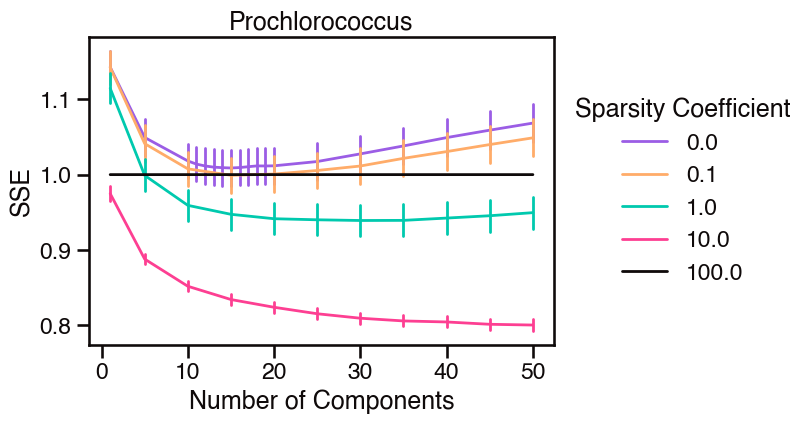

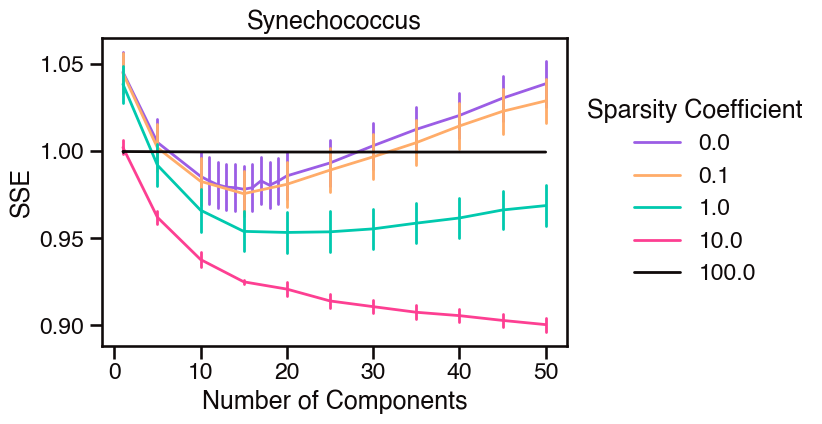

In [4]:
# look at relative_sse vs rank

for cyano in ['pro', 'syn']:
    # define data
    plot_df = results_df[results_df['genus'] == cyano]
    plot_df = plot_df[plot_df['comparison'] == 'Cross-Validation']
    plot_df = plot_df[plot_df['rank'].isin([1, 5, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 25, 30, 35, 40, 45, 50])]
    plot_df = plot_df[plot_df['lambda'].isin([0., 0.1, 1., 10., 100.])]

    # plot figure
    fig, axis = plt.subplots(figsize=(6, 4))
    sns.lineplot(
        x='rank', 
        y='relative_sse', 
        hue='Sparsity Coefficient', 
        errorbar='se', 
        err_style='bars', 
        data=plot_df,
        ax=axis, 
    );

    plt.title({'pro': 'Prochlorococcus', 'syn': 'Synechococcus'}[cyano])
    plt.xlabel('Number of Components');
    plt.ylabel('SSE')
    plt.legend(title='Sparsity Coefficient', loc='center left', bbox_to_anchor=[1, 0.5]);
    # plt.savefig(outdir / '{}-sse-v-rank.png'.format(cyano), bbox_inches='tight')


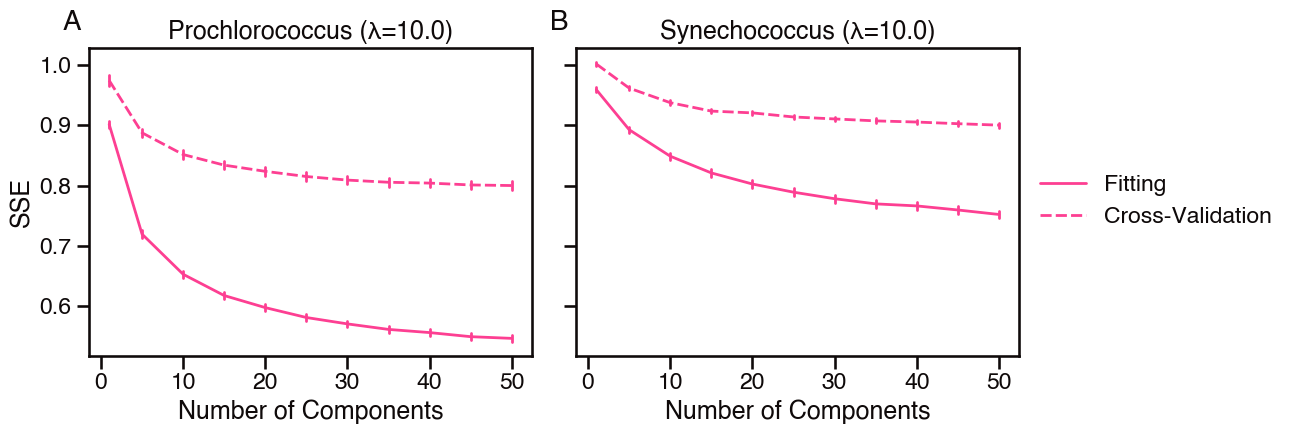

In [5]:
# look at relative_sse vs rank

# define data
bootstraps = np.arange(10)
lamb = 10.0

# set up subplots
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(12, 4), gridspec_kw={'wspace': 0.1})
annotations = {0: 'A', 1: 'B'}
annot_kws = dict(
    xy=(-0.06, 1.08), xycoords='axes fraction', va='center', ha='left', 
    weight='bold', fontsize=20, annotation_clip=False
)

for i, genus in enumerate(['pro', 'syn']):
    # define data
    plot_df = results_df[results_df['genus'] == genus]
    plot_df = plot_df[plot_df['lambda'] == lamb]
    plot_df = plot_df[plot_df['rank'].isin([1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 100, 200, 400, 800])]
    plot_df = plot_df[plot_df['bootstrap_id'].isin(bootstraps)]

    # plot figure
    sns.lineplot(
        x='rank', 
        y='relative_sse', 
        color=sns.color_palette()[3], 
        style='comparison', 
        errorbar='se', 
        err_style='bars', 
        data=plot_df,
        ax=axes[i], 
        legend=i
    );

    # labels and such
    axes[i].annotate(annotations[i], **annot_kws)
    axes[i].set(title='{} (λ={})'.format({'pro': 'Prochlorococcus', 'syn': 'Synechococcus'}[genus], lamb), 
                xlabel='Number of Components', ylabel='SSE')
    if i:
        axes[i].legend(loc='center left', bbox_to_anchor=[1, 0.5]);
    
    # save figure
    fig.savefig(outdir / 'high-rank-sse.png', bbox_inches='tight')
    

In [16]:
# find minimum SSE

summary_df = results_df[results_df['comparison'] == 'Cross-Validation']
# summary_df = summary_df[summary_df['lambda'].isin([0.0])]
summary_df = summary_df[summary_df['rank'].isin([15])]
summary_df.groupby(['genus', 'rank', 'lambda'])[['mean_gene_sparsity', 'relative_sse', 'fms_cv']].agg(
        mean_gene_sparsity=('mean_gene_sparsity', 'mean'), 
        relative_sse=('relative_sse', 'mean'), 
        fms_cv=('fms_cv', 'mean'), 
        bootstraps=('fms_cv', 'count')
    ).sort_values(
    # ['genus', 'relative_sse'], ascending=True
    ['genus', 'fms_cv'], ascending=[True, False]
).head(50)


mean_gene_sparsity  relative_sse    fms_cv  bootstraps
genus rank lambda                                                        
pro   15   17.0             40.544444      0.848585  0.541343          30
           12.0             77.840000      0.834322  0.540075          30
           14.0             60.977778      0.839195  0.537113          30
           10.0            103.882222      0.833922  0.536553          30
           13.0             68.793333      0.835780  0.534762          30
           16.0             46.698667      0.845926  0.534473         300
           11.0             90.737778      0.834069  0.531624          30
           20.0             28.093333      0.862745  0.530861          30
           18.0             35.666667      0.852484  0.527426          30
           15.0             54.251111      0.842723  0.523999          30
           6.0             194.951111      0.846062  0.522484          30
           5.0             238.777778      0.854420  0.522129          30
           4.0             309.588889      0.865791  0.520752          30
           7.0             160.868889      0.841662  0.520486          30
           2.0             688.922222      0.909324  0.518767          30
           8.0             138.920000      0.836573  0.517147          30
           19.0             31.991111      0.858397  0.515284          30
           9.0             118.062222      0.835134  0.514811          30
           22.0             22.553333      0.874397  0.511174          30
           1.0            1180.813333      0.947214  0.510374          30
           21.0             25.342222      0.869414  0.499290          30
           23.0             20.228889      0.880134  0.490992          30
           24.0             18.355556      0.885382  0.485927          30
           0.1            3025.655556      0.999096  0.480497          30
           25.0             16.188889      0.891496  0.474931          30
           26.0             14.255556      0.896017  0.467876          30
           27.0             12.642222      0.900848  0.465706          30
           28.0             11.271111      0.905840  0.458949          30
           30.0              9.182222      0.916255  0.432365          30
           29.0             10.664444      0.911544  0.431126          30
           31.0              8.133333      0.921009  0.413077          30
           32.0              7.555556      0.925767  0.388390          30
           0.0            5023.000000      1.008813  0.288223          30
           64.0              0.462222      0.992918  0.142744          30
           100.0             0.002222      0.999994  0.000000          30
syn   15   9.0             128.762222      0.924994  0.537796          30
           7.0             191.144444      0.926377  0.528679          30
           10.0            108.669333      0.925007  0.527207         300
           4.0             425.535556      0.931100  0.523935          30
           8.0             155.433333      0.926771  0.523459          30
           14.0             59.317778      0.929558  0.522813          30
           12.0             79.242222      0.927253  0.522400          30
           6.0             240.762222      0.928255  0.521528          30
           11.0             92.351111      0.926780  0.516561          30
           2.0            1022.326667      0.942913  0.513313          30
           5.0             309.348889      0.929639  0.508453          30
           13.0             67.962222      0.928712  0.507526          30
           18.0             35.048889      0.935958  0.505594          30
           1.0            1748.935556      0.953955  0.502066          30
           19.0             30.651111      0.938320  0.495995          30

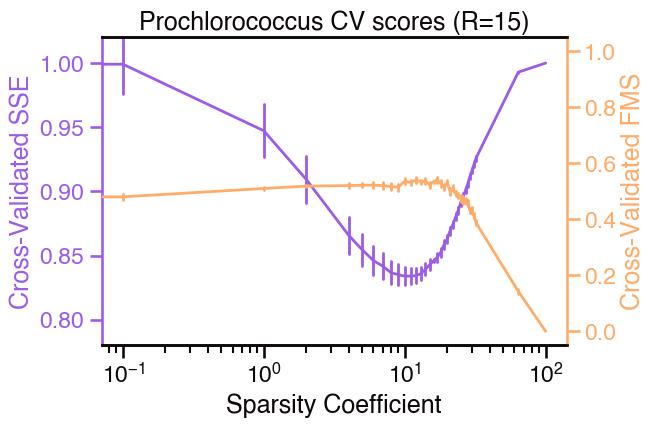

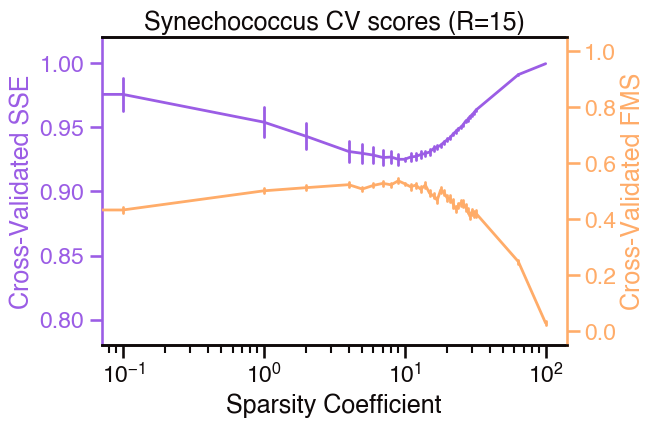

In [7]:
# look at SSE and FMS vs lambda

# define data
ranks = {'pro': 15, 'syn': 15}

for cyano in ['pro', 'syn']:
    rank = ranks[cyano]
    plot_df = results_df[results_df['genus'] == cyano]
    plot_df = plot_df[plot_df['comparison'] == 'Cross-Validation']
    plot_df = plot_df[plot_df['rank'] == rank]

    # plot SSE
    mpl.rcParams['axes.spines.left'] = True
    mpl.rcParams['axes.spines.right'] = False
    color = sns.color_palette()[0]
    fig, axis = plt.subplots(figsize=(6, 4))
    sns.lineplot(
        x='lambda', 
        y='relative_sse', 
        color=color, 
        errorbar='se', 
        err_style='bars',
        data=plot_df, 
        ax=axis, 
        legend=False
    )
    axis.set(ylim=[0.78, 1.02], xlabel='Sparsity Coefficient', ylabel='Cross-Validated SSE')
    axis.yaxis.label.set_color(color)
    axis.tick_params(axis='y', colors=color)
    axis.spines['left'].set_color(color)

    # plot FMS
    color = sns.color_palette()[1]
    mpl.rcParams['axes.spines.right'] = True
    mpl.rcParams['axes.spines.left'] = False
    axis2 = plt.twinx(axis)
    sns.lineplot(
        x='lambda', 
        y='fms_cv', 
        color=color, 
    #     style='rank', 
        errorbar='se', 
        err_style='bars',
        data=plot_df, 
        ax=axis2, 
        legend=False
    )
    axis2.set(ylim=[-.05, 1.05], xlabel='Sparsity Coefficient', ylabel='Cross-Validated FMS')
    axis2.yaxis.label.set_color(color)
    axis2.tick_params(axis='y', colors=color)
    axis2.spines['right'].set_color(color)

    # put defaults back where you found them
    mpl.rcParams['axes.spines.right'] = True
    mpl.rcParams['axes.spines.left'] = True

    # fix x axis stuff
    plt.xscale('log');
    plt.title('{} CV scores (R={})'.format({'pro': 'Prochlorococcus', 'syn': 'Synechococcus'}[cyano], rank));
    # plt.savefig(outdir / '{}-cv-scores-v-lambda.png'.format(cyano), bbox_inches='tight')


# Combined figure

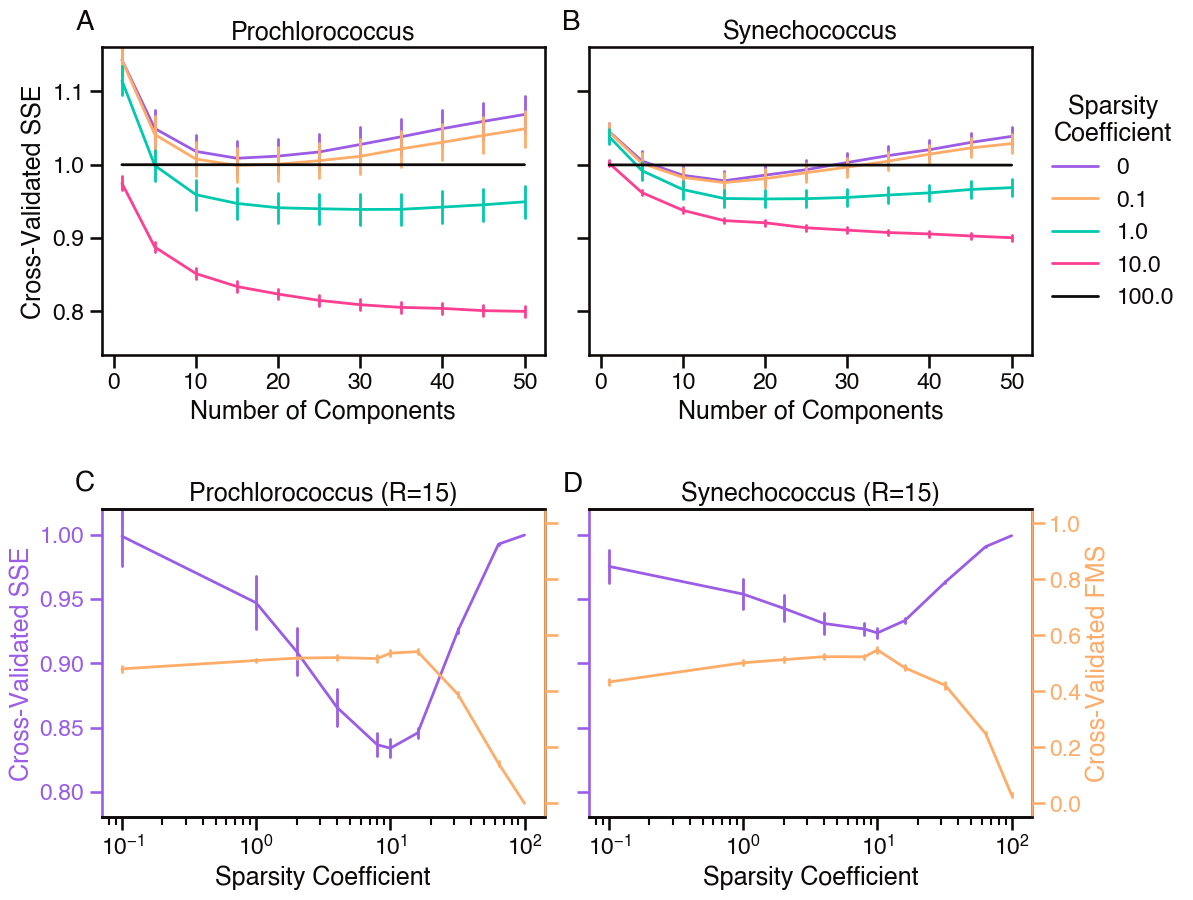

In [8]:
# combined fitting data panels

# define data to plot
plot_bootstraps = np.arange(10)
r_plot_ranks = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
r_plot_lambdas = [0, 0.1, 1., 10., 100.]
l_plot_ranks = {'pro': 15, 'syn': 15}
l_plot_lambdas = [0.1, 1., 2., 4., 8., 10., 16., 32., 64., 100.]

# set up subplots
fig, axes = plt.subplots(
    2, 2, figsize=(12, 10), gridspec_kw={'wspace': 0.1, 'hspace': 0.5}
)
annotations = {0: 'A', 1: 'B', 2: 'C', 3: 'D'}
annot_kws = dict(
    xy=(-0.06, 1.08), xycoords='axes fraction', va='center', ha='left', 
    weight='bold', fontsize=20, annotation_clip=False
)

# iterate through cyanobacteria
for i, genus in enumerate(['pro', 'syn']):
    # set up genus data
    data_df = results_df[results_df['genus'] == genus]
    data_df = data_df[data_df['bootstrap_id'].isin(plot_bootstraps)]
    data_df = data_df[data_df['modeled_replicate'] != data_df['comparison_replicate']]
    
    # make SSE vs. rank plot
    for j, lamb in enumerate(r_plot_lambdas):
        plot_df = data_df[data_df['rank'].isin(r_plot_ranks)]
        plot_df = plot_df[plot_df['lambda'] == lamb]
        sns.lineplot(
            x='rank', 
            y='relative_sse', 
            color=sns.color_palette()[j], 
            errorbar='se', 
            err_style='bars', 
            data=plot_df,
            ax=axes[0][i], 
            label=lamb, 
            legend=False
    );
    # set lables and such
    axes[0][i].annotate(annotations[i], **annot_kws)
    if i:
        axes[0][i].set(xlabel='Number of Components', ylabel=None, title='Synechococcus', ylim=[0.74, 1.16])
        axes[0][i].tick_params(labelleft=False)
        axes[0][i].legend(title='\t Sparsity\nCoefficient', alignment='center', 
                          loc='center left', bbox_to_anchor=(1, .5));
    else:
        axes[0][i].set(xlabel='Number of Components', ylabel='Cross-Validated SSE', 
                       title='Prochlorococcus', ylim=[0.74, 1.16])
        
    # make FMS & SSE vs. lambda plot
    plot_df = data_df[data_df['lambda'].isin(l_plot_lambdas)]
    plot_df = plot_df[plot_df['rank'] == l_plot_ranks[genus]]
    # plot SSE
    mpl.rcParams['axes.spines.left'] = True
    mpl.rcParams['axes.spines.right'] = False
    color = sns.color_palette()[0]
    sns.lineplot(
        x='lambda', 
        y='relative_sse', 
        color=color, 
        errorbar='se', 
        err_style='bars',
        data=plot_df, 
        ax=axes[1][i], 
        legend=False
    )
    # set lables and such
    axes[1][i].tick_params(axis='y', colors=color)
    axes[1][i].spines['left'].set_color(color)
    if i:
        axes[1][i].set(ylim=[0.78, 1.02], xlabel='Sparsity Coefficient', xscale='log', ylabel=None)
        axes[1][i].tick_params(labelleft=False)
    else:
        axes[1][i].set(ylim=[0.78, 1.02], xlabel='Sparsity Coefficient', xscale='log', ylabel='Cross-Validated SSE')
        axes[1][i].yaxis.label.set_color(color)

    # plot FMS
    color = sns.color_palette()[1]
    mpl.rcParams['axes.spines.right'] = True
    mpl.rcParams['axes.spines.left'] = False
    axis2 = plt.twinx(axes[1][i])
    sns.lineplot(
        x='lambda', 
        y='fms_cv', 
        color=color, 
        errorbar='se', 
        err_style='bars',
        data=plot_df, 
        ax=axis2, 
        legend=False
    )
    # set lables and such
    axis2.tick_params(axis='y', colors=color)
    axis2.spines['right'].set_color(color)
    axis2.set(title='{} (R={})'.format(
        {'pro': 'Prochlorococcus', 'syn': 'Synechococcus'}[genus], l_plot_ranks[genus]))
    axis2.annotate(annotations[2+i], **annot_kws)
    if i:
        axis2.set(ylim=[-.05, 1.05], xlabel='Sparsity Coefficient', xscale='log', ylabel='Cross-Validated FMS')
        axis2.yaxis.label.set_color(color)
    else:
        axis2.set(ylim=[-.05, 1.05], xlabel='Sparsity Coefficient', xscale='log', ylabel=None)
        axis2.tick_params(labelright=False)

    # put defaults back where you found them
    mpl.rcParams['axes.spines.right'] = True
    mpl.rcParams['axes.spines.left'] = True
    
fig.savefig(outdir / 'pro-syn-model-fitting.png', bbox_inches='tight')


# Other plots

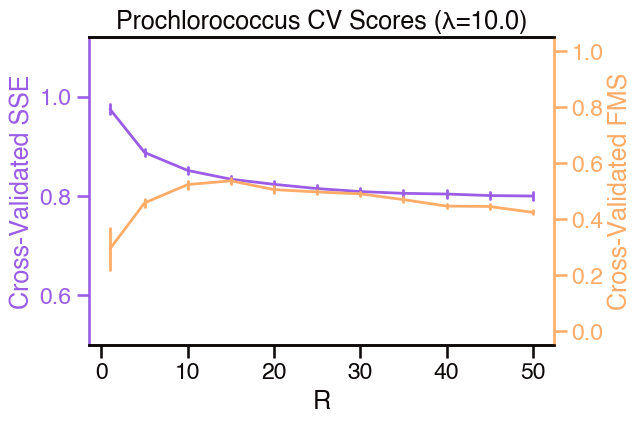

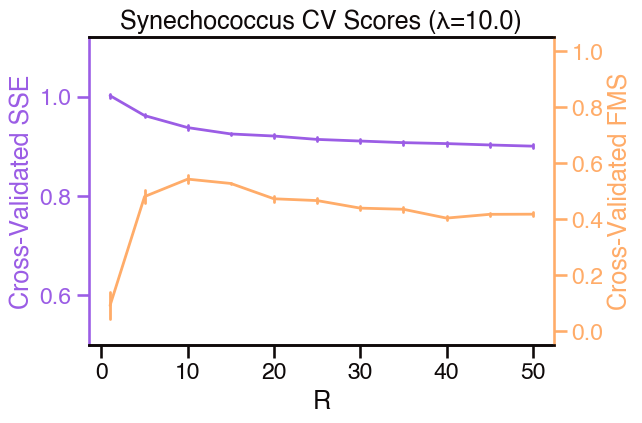

In [9]:
# look at SSE and FMS vs rank

# define data
lamb = 10.0

for cyano in ['pro', 'syn']:
    
    plot_df = results_df[results_df['genus'] == cyano]
    plot_df = plot_df[plot_df['comparison'] == 'Cross-Validation']
    plot_df = plot_df[plot_df['lambda'] == lamb]

    # plot SSE
    mpl.rcParams['axes.spines.left'] = True
    mpl.rcParams['axes.spines.right'] = False
    color = sns.color_palette()[0]
    fig, axis = plt.subplots(figsize=(6, 4))
    sns.lineplot(
        x='rank', 
        y='relative_sse', 
        color=color, 
        errorbar='se', 
        err_style='bars',
        data=plot_df, 
        ax=axis, 
        legend=False
    )
    axis.set(ylim=[0.5, 1.12], xlabel='R', ylabel='Cross-Validated SSE')
    axis.yaxis.label.set_color(color)
    axis.tick_params(axis='y', colors=color)
    axis.spines['left'].set_color(color)

    # plot FMS
    color = sns.color_palette()[1]
    mpl.rcParams['axes.spines.right'] = True
    mpl.rcParams['axes.spines.left'] = False
    axis2 = plt.twinx(axis)
    sns.lineplot(
        x='rank', 
        y='fms_cv', 
        color=color, 
        errorbar='se', 
        err_style='bars',
        data=plot_df, 
        ax=axis2, 
        legend=False
    )
    axis2.set(ylim=[-.05, 1.05], xlabel='R', ylabel='Cross-Validated FMS')
    axis2.yaxis.label.set_color(color)
    axis2.tick_params(axis='y', colors=color)
    axis2.spines['right'].set_color(color)

    # put defaults back where you found them
    mpl.rcParams['axes.spines.right'] = True
    mpl.rcParams['axes.spines.left'] = True

    # fix x axis stuff
    plt.title('{} CV Scores (λ={})'.format({'pro': 'Prochlorococcus', 'syn': 'Synechococcus'}[cyano], lamb));
    # plt.savefig(outdir / '{}-cv-scores-v-rank.png'.format(cyano), bbox_inches='tight')


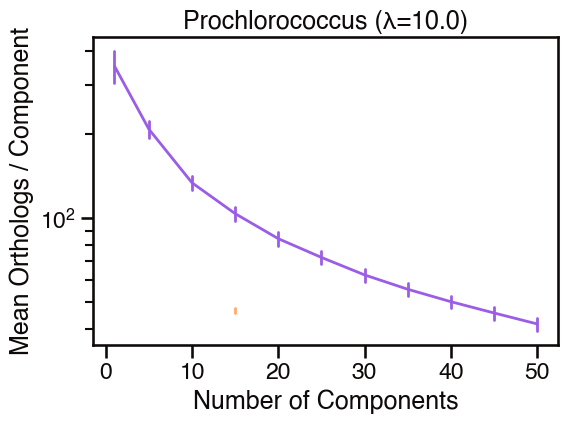

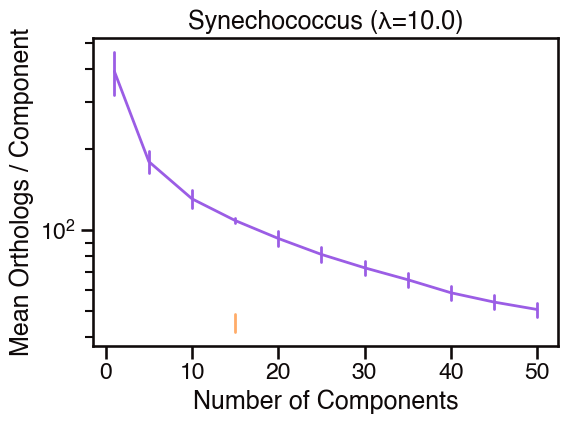

In [10]:
# look at number of nonzero components with rank

# define data
lambs = [10.0, 16.0]
for cyano in ['pro', 'syn']:
    # pull data together
    plot_df = results_df[results_df['genus'] == cyano]
    plot_df = plot_df[plot_df['comparison'] == 'Fitting']
    plot_df = plot_df[plot_df['lambda'].isin(lambs)]
    # plot figure
    fig, axis = plt.subplots(figsize=(6, 4))
    sns.lineplot(
        x='rank', 
        y='mean_gene_sparsity', 
        hue='Sparsity Coefficient', 
        errorbar='se', 
        err_style='bars', 
        data=plot_df,
        legend=False, 
        ax=axis
    );
    # fix axes and stuff
    axis.set(
        xlabel='Number of Components', ylabel='Mean Orthologs / Component', yscale='log', 
        title='{} (λ={})'.format({'pro': 'Prochlorococcus', 'syn': 'Synechococcus'}[cyano], lamb)
    )
    # plt.savefig(outdir / '{}-ncomponents-v-rank.png'.format(cyano), bbox_inches='tight')
